# 第04回データ分析勉強会（2020/01/14）

## データの前処理

使用データ：[Kickstarter Projects](https://www.kaggle.com/kemical/kickstarter-projects) <br>
参考URL：<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　～コード説明１～"](https://ds-blog.tbtech.co.jp/entry/2019/04/19/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E3%82%B3%E3%83%BC%E3%83%89%E8%AA%AC%E6%98%8E%EF%BC%91%EF%BD%9E)<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　～コード説明２～"](https://ds-blog.tbtech.co.jp/entry/2019/04/27/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E3%82%B3%E3%83%BC%E3%83%89%E8%AA%AC%E6%98%8E%EF%BC%92%EF%BD%9E)

# import libraries

ライブラリについては[コチラ](https://www.tech-teacher.jp/blog/python-import/)の記事を参照。簡単に説明するならば、Pythonでは関数やクラスなどをまとめて書いたファイルをモジュールと呼び、モジュールを複数まとめたものをライブラリと呼ぶ。importすることで利用可能。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix 
from sklearn.metrics import mean_absolute_error
import datetime as dt
%matplotlib inline
sns.set()

# read data

ここではデータを実際に読み込む。配布データはzip形式で圧縮されているので解凍してからデータを読み込む。

In [2]:
!unzip input/archive.zip -d input

Archive:  input/archive.zip
replace input/ks-projects-201612.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import codecs 
with codecs.open('input/ks-projects-201612.csv', 'r', 'utf-8', 'ignore') as file:
    df = pd.read_csv(file, delimiter=",")
df.columns = df.columns.str.replace(" ", "")
df = df.loc[:, ~df.columns.str.match('Unnamed')]

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usdpledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375


# data handling

ここで取得したデータ自体を前処理を行い、分析するためのデータを作成していく。取得したデータは欠損値・異常値が含まれている場合が大半で、そのまま（ローデータ）の状態で分析をすることはまず無い。分析するためにローデータを加工しなければならなく、<span style="color: red; ">データ分析の工数の８割を占めるほど重要な工程</span>。

## データの変数

| 変数名         | 詳細                                      | 
| ------------- | ---------------------------------------- | 
| ID            | クラウドファンディングの個別ID                | 
| name          | クラウドファンディングの名前                  | 
| category      | 詳細なカテゴリー                            | 
| main_category | 大まかなカテゴリー                          | 
| currency      | 使用された通貨                             | 
| deadline      | 締め切り日時                               | 
| goal          | 目標調達資金額                             | 
| launched      | 開始した日時                               | 
| pledged       | 集まった資金                               | 
| state         | プロジェクトの状態(成功、失敗、キャンセルなど)  | 
| backer        | 集まった支援者                             | 
| country       | プロジェクトが開かれた国                     | 
| usd pledged   | 集まった資金の米ドル換算                     | 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             323750 non-null  int64 
 1   name           323745 non-null  object
 2   category       323745 non-null  object
 3   main_category  323750 non-null  object
 4   currency       323750 non-null  object
 5   deadline       323750 non-null  object
 6   goal           323750 non-null  object
 7   launched       323750 non-null  object
 8   pledged        323750 non-null  object
 9   state          323750 non-null  object
 10  backers        323750 non-null  object
 11  country        323750 non-null  object
 12  usdpledged     319960 non-null  object
dtypes: int64(1), object(12)
memory usage: 32.1+ MB


In [5]:
df.isnull().sum()

ID                  0
name                5
category            5
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usdpledged       3790
dtype: int64

## create variavle

今回のデータでは、そのまま使用することが難しそうな変数がある。例えば、"deadline"と"launched"。具体的な日付自体を確認して得られるものは無く、それより当該プロジェクトが発足してから締切までの経過日数の方が重要だと考えられるので、経過日数の変数を作成する。

In [6]:
df['deadline'] = pd.to_datetime(df['deadline'], errors = 'coerce')
df['launched'] = pd.to_datetime(df['launched'], errors = 'coerce')
df['period'] = (df['deadline'] - df['launched']).dt.days
df = df.drop(['deadline', 'launched'], axis=1)

## data type convert

プログラミングにおいて「変数」には**型**というものがある。データ分析においても型(data type)は重要であり、それによって分析結果が変わったり、そもそも分析ができなかったりする。Pythonでの変数の型について詳しくは[コチラ](https://ai-inter1.com/python-data_type/)の記事等を参照。

In [7]:
df['goal'] = pd.to_numeric(df['goal'], errors ='coerce')
df['pledged'] = pd.to_numeric(df['pledged'], errors ='coerce')
df['backers'] = pd.to_numeric(df['backers'], errors ='coerce')
df['usdpledged'] = pd.to_numeric(df['usdpledged'], errors ='coerce')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             323750 non-null  int64  
 1   name           323745 non-null  object 
 2   category       323745 non-null  object 
 3   main_category  323750 non-null  object 
 4   currency       323750 non-null  object 
 5   goal           323118 non-null  float64
 6   pledged        323126 non-null  float64
 7   state          323750 non-null  object 
 8   backers        323127 non-null  float64
 9   country        323750 non-null  object 
 10  usdpledged     319337 non-null  float64
 11  period         323118 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 29.6+ MB


## data select

分析に使用しないデータを読み込んでいても意味が無いし、メモリ上に置いておいてもそれについて思考すること自体に脳のリソースを割く必要も無いので、使用するデータだけをメモリ上に残しておく。もし後で必要になった場合はそのときに再度読み込めばいい。

In [9]:
df = df.drop(['ID','name','category','country'], axis=1)

In [10]:
df.head()

,main_category,currency,goal,pledged,state,backers,usdpledged,period
0,Publishing,GBP,1000.0,0.0,failed,0.0,0.0,58.0
1,Film & Video,USD,45000.0,220.0,failed,3.0,220.0,45.0
2,Music,USD,5000.0,1.0,failed,1.0,1.0,30.0
3,Film & Video,USD,19500.0,1283.0,canceled,14.0,1283.0,55.0
4,Food,USD,50000.0,52375.0,successful,224.0,52375.0,35.0


## missing value handling

欠損値があるレコード（行）に対して何かしらの対処を行う。欠損値があるとその列に処理を行うことができなくなってしまう。

In [11]:
df.isnull().sum()

main_category       0
currency            0
goal              632
pledged           624
state               0
backers           623
usdpledged       4413
period            632
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   main_category  323750 non-null  object 
 1   currency       323750 non-null  object 
 2   goal           323118 non-null  float64
 3   pledged        323126 non-null  float64
 4   state          323750 non-null  object 
 5   backers        323127 non-null  float64
 6   usdpledged     319337 non-null  float64
 7   period         323118 non-null  float64
dtypes: float64(5), object(3)
memory usage: 19.8+ MB


In [13]:
df = df.dropna()

In [14]:
df.isnull().sum()

main_category    0
currency         0
goal             0
pledged          0
state            0
backers          0
usdpledged       0
period           0
dtype: int64

## Correlation

データの相関関係を確認する。相関が強い変数があると学習が不安定になり、係数の解釈性に信用性がなくなることがある。

In [15]:
df.corr()

,goal,pledged,backers,usdpledged,period
goal,1.000000,0.006767,0.004920,0.006279,0.003954
pledged,0.006767,1.000000,0.745843,0.947781,0.000511
backers,0.004920,0.745843,1.000000,0.714949,-0.001006
usdpledged,0.006279,0.947781,0.714949,1.000000,0.000435
period,0.003954,0.000511,-0.001006,0.000435,1.000000


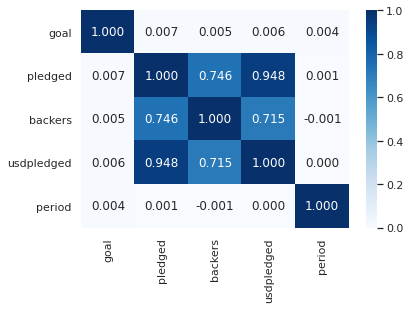

In [16]:
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='1.3f')
plt.show()

## Convert the correlation to zero.

データ自体に強い相関関係が認められたので、相関を無相関化する。<br>
無相関化について数学的背景を知りたい方は[コチラ](https://qiita.com/Hawaii/items/37c0398a7d2afc8dbedb)の記事を参照。

In [17]:
df_pledged = pd.DataFrame({'pledged' : df['pledged'], 'usdpledged' : df['usdpledged']})
cov = np.cov(df_pledged, rowvar=0)
_, S = np.linalg.eig(cov)
pledged_decorr = np.dot(S.T, df_pledged.T).T

相関係数: -0.000


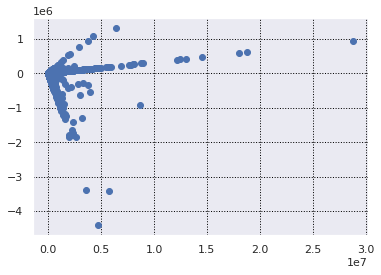

In [18]:
print('相関係数: {:.3f}'.format(np.corrcoef(pledged_decorr[:, 0], pledged_decorr[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(pledged_decorr[:, 0], pledged_decorr[:, 1], 'o')
plt.show()

In [19]:
# 無相関化した変数を元のデータセットに返す。
pledged_decorr = pd.DataFrame(pledged_decorr, columns=['pledged','uspledged'])
df['pledged'] = pledged_decorr.loc[:,'pledged']
df['usdpledged'] = pledged_decorr.loc[:,'uspledged']

## Convert the variable to dummy.

In [20]:
df['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [21]:
df_dummy = pd.get_dummies(df['main_category'])
df = pd.concat([df.drop(['main_category'],axis=1),df_dummy],axis=1)

In [22]:
df_dummy = pd.get_dummies(df['currency'])
df = pd.concat([df.drop(['currency'],axis=1),df_dummy],axis=1)

In [23]:
df.head()

,goal,pledged,state,backers,usdpledged,period,Art,Comics,Crafts,Dance,...,DKK,EUR,GBP,HKD,MXN,NOK,NZD,SEK,SGD,USD
0,1000.0,0.000000,failed,0.0,0.000000,58.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,45000.0,310.967861,failed,3.0,9.949343,45.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5000.0,1.413490,failed,1.0,0.045224,30.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19500.0,1813.508026,canceled,14.0,58.022762,55.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,50000.0,74031.553269,successful,224.0,2368.622091,35.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Hold out

ホールドアウト法とは、データを予め訓練用とテスト用に分割しておき、学習させたモデルを評価データで評価し、モデルの精度を確かめる方法のこと。

In [24]:
y = df['state'].values
X = df.drop('state', axis=1).values

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

## standardization

標準化とは、与えられたデータを平均が0で分散が1のデータに変換することで、データスケールを揃えて、計算や比較をしやすくする。

In [25]:
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

# reconfirmation the data

本日データを前処理した結果を最後に再確認する。[read data](#read-data)で読み込んだデータと再度比較してもらうとかなり変化していることが分かると思う。

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319328 entries, 0 to 323749
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   goal          319328 non-null  float64
 1   pledged       314973 non-null  float64
 2   state         319328 non-null  object 
 3   backers       319328 non-null  float64
 4   usdpledged    314973 non-null  float64
 5   period        319328 non-null  float64
 6   Art           319328 non-null  uint8  
 7   Comics        319328 non-null  uint8  
 8   Crafts        319328 non-null  uint8  
 9   Dance         319328 non-null  uint8  
 10  Design        319328 non-null  uint8  
 11  Fashion       319328 non-null  uint8  
 12  Film & Video  319328 non-null  uint8  
 13  Food          319328 non-null  uint8  
 14  Games         319328 non-null  uint8  
 15  Journalism    319328 non-null  uint8  
 16  Music         319328 non-null  uint8  
 17  Photography   319328 non-null  uint8  
 18  Publ

In [27]:
# default=20
pd.set_option('display.max_columns', 50)

In [28]:
df

,goal,pledged,state,backers,usdpledged,period,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater,AUD,CAD,CHF,DKK,EUR,GBP,HKD,MXN,NOK,NZD,SEK,SGD,USD
0,1000.0,0.000000,failed,0.0,0.000000,58.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,45000.0,310.967861,failed,3.0,9.949343,45.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5000.0,1.413490,failed,1.0,0.045224,30.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,19500.0,1813.508026,canceled,14.0,58.022762,55.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,50000.0,74031.553269,successful,224.0,2368.622091,35.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323745,50000.0,NaN,canceled,1.0,NaN,30.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
323746,1500.0,NaN,failed,5.0,NaN,27.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
323747,15000.0,NaN,failed,1.0,NaN,45.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
323748,15000.0,NaN,failed,6.0,NaN,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
